In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import scale, OneHotEncoder

# Data Preparation
We have a mixture of categorical and numerical information. Before modelling we must:
1. Remove or fill null values
2. Make some assumptions about each feature
2. Prepare features such that we can input all as numerical
3. Normalise features as needed and remove outliers

In [2]:
superstore_data = pd.read_csv(r"/kaggle/input/superstore-marketing-campaign-dataset/superstore_data.csv")

**Removing/Filling null values**
As we have 24 null incomes, we will remove these rather than make any assumptions about zero income.

In [3]:
superstore_data.apply(lambda x: sum(x.isnull()),axis=0)

Id                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64

In [4]:
superstore_data = superstore_data.dropna(subset=["Income"])

# Year of Birth
We assume that the current year is 2023. 
We find some outliers that seem to make some customers more than 123 years old, so we remove these

(array([  3.,   0.,   0.,   0.,  15., 298., 533., 678., 502., 187.]),
 array([1893. , 1903.3, 1913.6, 1923.9, 1934.2, 1944.5, 1954.8, 1965.1,
        1975.4, 1985.7, 1996. ]),
 <BarContainer object of 10 artists>)

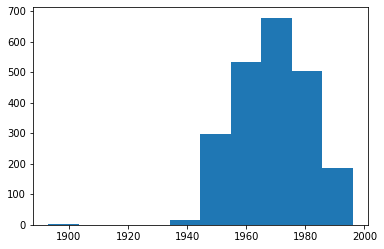

In [5]:
plt.hist(superstore_data["Year_Birth"])

In [6]:
def find_iqr_outliers(input_array):

    q1, q3 = np.percentile(input_array,[25,75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)
    print("Lower bound: " + str(lower_bound) + " | Upper bound: " + str(upper_bound))
    
    outlier_indices = np.where((input_array<lower_bound) | (input_array>upper_bound))
    print("Outliers : " + str(list(input_array.iloc[outlier_indices])))
    return outlier_indices, [lower_bound,upper_bound]

In [7]:
superstore_data = superstore_data.drop(superstore_data.index[find_iqr_outliers(superstore_data["Year_Birth"])[0]])
superstore_data["Year_Birth"] = 2023 - superstore_data["Year_Birth"]
superstore_data["Year_Birth"] /= max(superstore_data["Year_Birth"])

Lower bound: 1932.0 | Upper bound: 2004.0
Outliers : [1893, 1899, 1900]


# Education
We find initially that there are not very many customers with "Basic" education. 2n cycle is difficult to interpret as I am a UK student. We collect these into three categories: Basic, Undergrad, and Postgrad (2n Cycle, Master, PhD)

In [8]:
original_distribution = np.unique(superstore_data["Education"],return_counts=True)
education_mapping = {"Basic":"Basic","Graduation":"Undergrad","2n Cycle":"Postgrad","Master":"Postgrad","PhD":"Postgrad"}
superstore_data["Education"] = superstore_data["Education"].map(education_mapping)
new_distribution = np.unique(superstore_data["Education"],return_counts=True)

<BarContainer object of 3 artists>

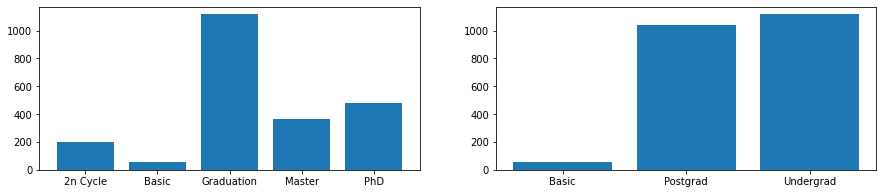

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
axes[0].bar(original_distribution[0],original_distribution[1])
axes[1].bar(new_distribution[0],new_distribution[1])

In [10]:
education_dummy = pd.get_dummies(superstore_data["Education"])
education_dummy = education_dummy.drop(["Basic"],axis=1)
superstore_data = pd.concat([superstore_data,education_dummy],axis = 1)
superstore_data = superstore_data.drop(["Education"],axis=1)

In [11]:
superstore_data

,Id,Year_Birth,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Postgrad,Undergrad
0,1826,0.638554,Divorced,84835.0,0,0,6/16/2014,0,189,104,...,218,1,4,4,6,1,1,0,0,1
1,1,0.746988,Single,57091.0,0,0,6/15/2014,0,464,5,...,37,1,7,3,7,5,1,0,0,1
2,10476,0.783133,Married,67267.0,0,1,5/13/2014,0,134,11,...,30,1,3,2,5,2,0,0,0,1
3,1386,0.674699,Together,32474.0,1,1,11/5/2014,0,10,0,...,0,1,1,0,2,7,0,0,0,1
4,5371,0.409639,Single,21474.0,1,0,8/4/2014,0,6,16,...,34,2,3,1,2,7,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,0.566265,Divorced,66476.0,0,1,7/3/2013,99,372,18,...,78,2,5,2,11,4,0,0,1,0
2236,5263,0.554217,Married,31056.0,1,0,1/22/2013,99,5,10,...,16,1,1,0,3,8,0,0,1,0
2237,22,0.566265,Divorced,46310.0,1,0,3/12/2012,99,185,2,...,14,2,6,1,5,8,0,0,0,1
2238,528,0.542169,Married,65819.0,0,0,11/29/2012,99,267,38,...,63,1,5,4,10,3,0,0,0,1


# Marital Status
We see some invalid answers to the question such as "Absurd", "Alone", and "YOLO". We remove these as there are only 2/3 entries.

We group together Divorced and Widow, as they represent some break in partnership and there are not such a substantial amount of widowers that they require a category.

In [12]:
np.unique(superstore_data["Marital_Status"],return_counts=True)

(array(['Absurd', 'Alone', 'Divorced', 'Married', 'Single', 'Together',
        'Widow', 'YOLO'], dtype=object),
 array([  2,   3, 231, 857, 470, 572,  76,   2]))

In [13]:
superstore_data = superstore_data[~superstore_data["Marital_Status"].isin(["Absurd","Alone","YOLO"])]

marital_mapping = {"Divorced":"Seperated","Married":"Married","Single":"Single","Together":"Together","Widow":"Seperated"}
superstore_data["Marital_Status"] = superstore_data["Marital_Status"].map(marital_mapping)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
np.unique(superstore_data["Marital_Status"],return_counts=True)

(array(['Married', 'Seperated', 'Single', 'Together'], dtype=object),
 array([857, 307, 470, 572]))

In [15]:
marital_dummy = pd.get_dummies(superstore_data["Marital_Status"])
marital_dummy = marital_dummy.drop(["Single"],axis=1)
superstore_data = pd.concat([superstore_data,marital_dummy],axis = 1)
superstore_data = superstore_data.drop(["Marital_Status"],axis=1)

# Income
We see that none of the outliers redeemed the offer. With this in mind we (probably incorrectly depending on more data) exclude higher income than 118667.25

We standardise Income and test normality under some standard transforms. We see that the untransformed data now follows a very standard looking normal curve, so we use this.

In [16]:
superstore_data.iloc[find_iqr_outliers(superstore_data["Income"])[0]]

Lower bound: -14866.75 | Upper bound: 118667.25
Outliers : [157146.0, 160803.0, 666666.0, 162397.0, 157733.0, 153924.0, 156924.0, 157243.0]


,Id,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Postgrad,Undergrad,Married,Seperated,Together
325,4931,0.554217,157146.0,0,0,4/29/2013,13,1,0,1725,...,28,0,1,0,0,0,1,0,0,1
497,1501,0.493976,160803.0,0,0,4/8/2012,21,55,16,1622,...,28,1,0,0,0,1,0,1,0,0
527,9432,0.554217,666666.0,1,0,2/6/2013,23,9,14,18,...,1,3,6,0,0,0,1,0,0,1
731,1503,0.566265,162397.0,1,1,3/6/2013,31,85,1,16,...,0,1,1,0,0,1,0,0,0,1
853,5336,0.626506,157733.0,1,0,4/6/2013,37,39,1,9,...,0,1,1,0,0,1,0,0,0,1
1826,5555,0.578313,153924.0,0,0,7/2/2014,81,1,1,1,...,0,0,0,0,0,0,1,0,1,0
1925,11181,0.891566,156924.0,0,0,8/29/2013,85,2,1,2,...,0,0,0,0,0,1,0,1,0,0
2204,8475,0.602410,157243.0,0,1,1/3/2014,98,20,2,1582,...,22,0,0,0,0,1,0,1,0,0


In [17]:
superstore_data = superstore_data.drop(superstore_data.index[find_iqr_outliers(superstore_data["Income"])[0]])

Lower bound: -14866.75 | Upper bound: 118667.25
Outliers : [157146.0, 160803.0, 666666.0, 162397.0, 157733.0, 153924.0, 156924.0, 157243.0]


[  1730.   2447.   3502. ... 102692. 105471. 113734.]
ShapiroResult(statistic=0.9844251871109009, pvalue=9.100666827934183e-15)
9.098097777005161e-15
1.735088069189253e-33
4.779152866656835e-23


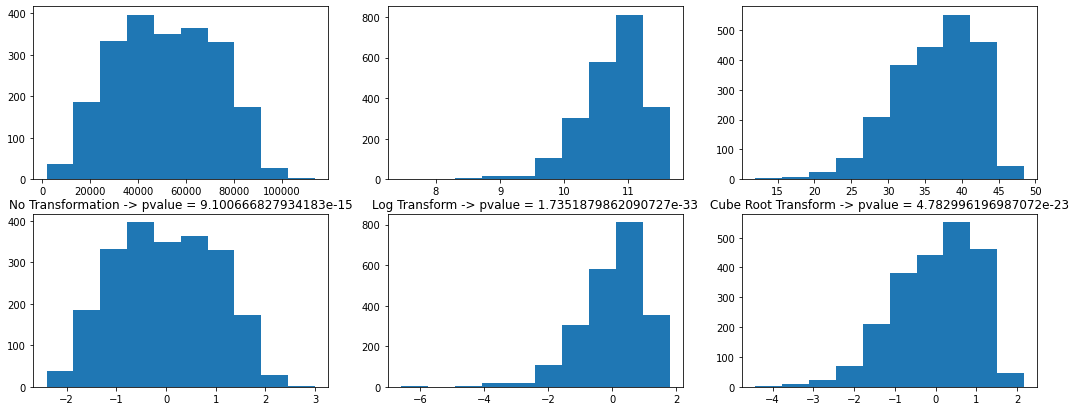

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 7))
print(np.sort(superstore_data["Income"]))
proposals = [superstore_data["Income"],
            np.log(superstore_data["Income"]),
            np.power(superstore_data["Income"],1/3)]
proposal_titles = ["No Transformation","Log Transform","Cube Root Transform"]

print(shapiro(scale(list(superstore_data["Income"]))))

for i in range(3):
    axes[0,i].hist(proposals[i])
    axes[1,i].hist(scale(proposals[i]))
    print(shapiro(np.array(proposals[i])).pvalue)
    axes[1,i].set_title(proposal_titles[i] + " -> pvalue = " + str(shapiro(scale(list(proposals[i]))).pvalue))
fig.show()

In [19]:
superstore_data["Income"] = scale(superstore_data["Income"])

# Kidhome and Teenhome

For both categories, we see that there is a very small amount of households with value 2, hence we turn this into a binary predictor of either having a kidhome/teenhome or not.

In [20]:
original_kidhome = superstore_data["Kidhome"]
new_kidhome = (superstore_data["Kidhome"]>0).astype(int)
original_teenhome = superstore_data["Teenhome"]
new_teenhome = (superstore_data["Teenhome"]>0).astype(int)
print("Kids home: "+ str(np.unique(original_kidhome,return_counts=True)) + "  --->  Has Kids: " + str(np.unique(new_kidhome,return_counts=True)))
print("Teen home: "+ str(np.unique(original_teenhome,return_counts=True)) + "  --->  Has Teens: " + str(np.unique(new_teenhome,return_counts=True)))

Kids home: (array([0, 1, 2]), array([1272,  880,   46]))  --->  Has Kids: (array([0, 1]), array([1272,  926]))
Teen home: (array([0, 1, 2]), array([1136, 1011,   51]))  --->  Has Teens: (array([0, 1]), array([1136, 1062]))


In [21]:
superstore_data["Kidhome"] = (superstore_data["Kidhome"]>0).astype(int)
superstore_data["Teenhome"] = (superstore_data["Teenhome"]>0).astype(int)

# Dt_Customer
We assume that the day of the week/month **WILL NOT** have a major effect on the outcome.

We take the year and month of sign-up as features. With the years being transformed into years since sign up, and having the month encoded using a sine-cosine transformation into a continuous 2D space (for now, could refactor this into onehot encoding)


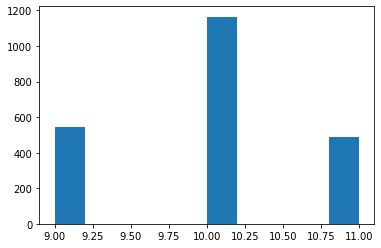

In [22]:
import datetime
from math import sin, cos, pi
dttm_cust = pd.to_datetime(superstore_data["Dt_Customer"],format="%m/%d/%Y")

sin_time = dttm_cust.map(lambda dt: sin(2* pi * dt.month/12))
cos_time = dttm_cust.map(lambda dt: cos(2* pi * dt.month/12))

years_customer = dttm_cust.map(lambda dt: 2023-dt.year)
plt.hist(years_customer)
years_customer /= max(years_customer)

superstore_data = superstore_data.drop(['Dt_Customer'],axis=1)

superstore_data["Customer_Month_Sin"] = sin_time
superstore_data["Customer_Month_Cos"] = cos_time
superstore_data["Customer_Years"] = years_customer

# Recency

As we can see outliers above 100 do not exist, we normalise data from 0-100 to 0-1

(array([230., 218., 231., 209., 212., 230., 211., 223., 221., 213.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

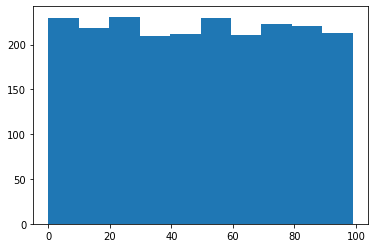

In [23]:
plt.hist(superstore_data["Recency"])

In [24]:
superstore_data["Recency"] = superstore_data["Recency"]/100

# Amount Spent in Category

We see immediately that each category is largely expontentially distributed.

We test both the log transform and the standardised log transform to visualise the data. We see from observation that we could excuse using a standardised approach for Meat and Gold, but for uniformality, we will use a normalisation between 0 and 1 of the log transform to make predictors more understandable

In [25]:
mnt_cols = ["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"]
mnt_indices = [superstore_data.columns.get_loc(mnt_col) for mnt_col in mnt_cols]

In [26]:
for i in range(len(mnt_indices)):
    superstore_data.loc[superstore_data[mnt_cols[i]] == 0,mnt_cols[i]]=1
    print(min(superstore_data[mnt_cols[i]]))

1
1
1
1
1
1


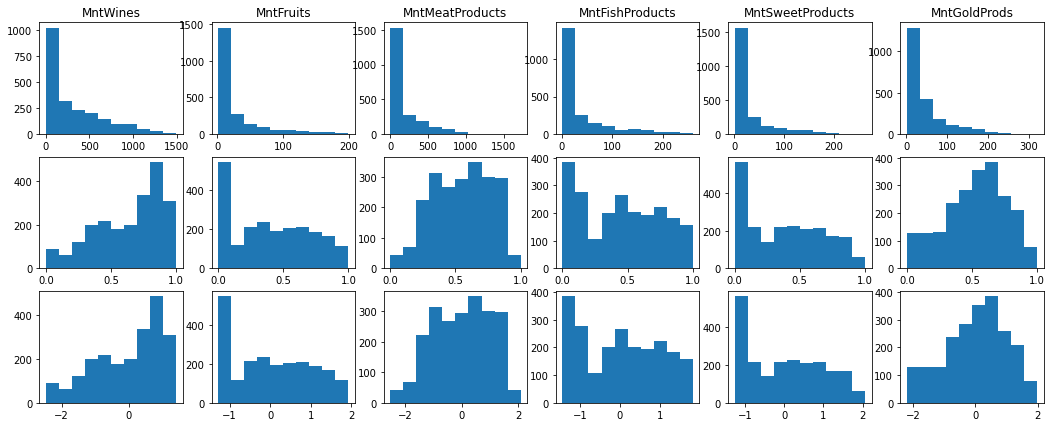

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=len(mnt_indices), figsize=(18, 7))


for i in range(len(mnt_indices)):
    axes[0,i].hist(superstore_data[mnt_cols[i]])
    axes[0,i].set_title(str(mnt_cols[i]))
    log_transform = np.log(superstore_data[mnt_cols[i]])
    axes[1,i].hist(log_transform/max(log_transform))
    axes[2,i].hist(scale(log_transform))
    

In [28]:
for i in range(len(mnt_indices)):
    log_transform = np.log(superstore_data[mnt_cols[i]])
    superstore_data[mnt_cols[i]] = log_transform/max(log_transform)

# Number of Deals/WebPurchases/Catalog/Store/WebVisits

In [29]:
num_cols = ["NumDealsPurchases",
"NumCatalogPurchases",
"NumStorePurchases",
"NumWebPurchases",
"NumWebVisitsMonth"]
num_indices = [superstore_data.columns.get_loc(num_col) for num_col in num_cols]

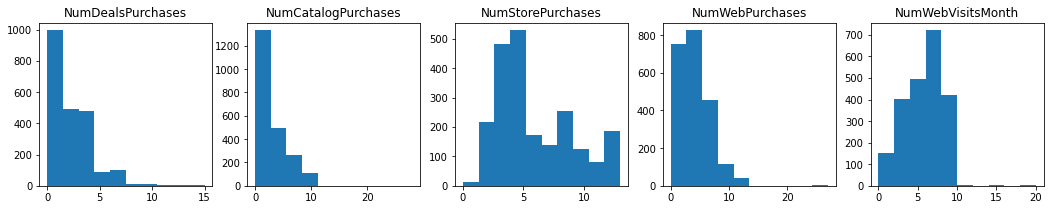

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(18, 3))
for i in range(len(num_indices)):
    axes[i].hist(superstore_data[num_cols[i]])
    axes[i].set_title(str(num_cols[i]))
    

In [31]:

for i in range(len(num_indices)):
    iqr_stats = find_iqr_outliers(superstore_data[num_cols[i]])
    for index in iqr_stats[0][0]:
        superstore_data.iloc[index,[num_indices[i]]] = iqr_stats[1][1]
    superstore_data[num_cols[i]]/=max(superstore_data[num_cols[i]])

Lower bound: -2.0 | Upper bound: 6.0
Outliers : [12, 12, 7, 11, 11, 9, 8, 7, 9, 10, 7, 11, 10, 12, 10, 8, 7, 7, 7, 11, 7, 15, 8, 9, 9, 7, 7, 9, 7, 10, 15, 7, 8, 7, 7, 9, 8, 8, 8, 7, 8, 7, 8, 7, 11, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 9, 15, 7, 9, 15, 7, 7, 7, 8, 7, 8, 13, 13, 15, 8, 7, 7, 7, 8, 7, 13, 7, 7, 7, 7, 7, 10]
Lower bound: -6.0 | Upper bound: 10.0
Outliers : [11, 11, 11, 11, 11, 11, 11, 11, 28, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
Lower bound: -4.5 | Upper bound: 15.5
Outliers : []
Lower bound: -4.0 | Upper bound: 12.0
Outliers : [25, 27, 23]
Lower bound: -3.0 | Upper bound: 13.0
Outliers : [17, 14, 19, 14, 19, 20, 20, 20]


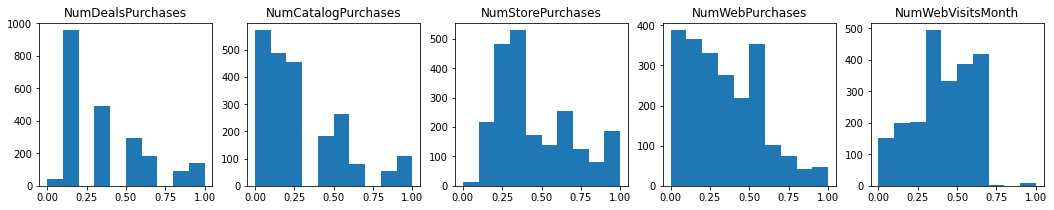

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(18, 3))
for i in range(len(num_indices)):
    axes[i].hist(superstore_data[num_cols[i]])
    axes[i].set_title(str(num_cols[i]))

In [33]:
superstore_data

,Id,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Response,Complain,Postgrad,Undergrad,Married,Seperated,Together,Customer_Month_Sin,Customer_Month_Cos,Customer_Years
0,1826,0.638554,1.602923,0,0,0.00,0.717208,0.877409,0.796666,0.847521,...,1,0,0,1,0,1,0,1.224647e-16,-1.000000e+00,0.818182
1,1,0.746988,0.264153,0,0,0.00,0.840097,0.304052,0.558016,0.350184,...,1,0,0,1,0,0,0,1.224647e-16,-1.000000e+00,0.818182
2,10476,0.783133,0.755190,0,1,0.00,0.670153,0.453005,0.547101,0.487337,...,0,0,0,1,1,0,0,5.000000e-01,-8.660254e-01,0.818182
3,1386,0.674699,-0.923724,1,1,0.00,0.315054,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,1,-5.000000e-01,8.660254e-01,0.818182
4,5371,0.409639,-1.454523,1,0,0.00,0.245160,0.523792,0.426414,0.431522,...,1,0,0,1,0,0,0,-8.660254e-01,-5.000000e-01,0.818182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,0.566265,0.717021,0,1,0.99,0.809860,0.546043,0.648906,0.692868,...,0,0,1,0,0,1,0,-5.000000e-01,-8.660254e-01,0.909091
2236,5263,0.554217,-0.992149,1,0,0.99,0.220213,0.435000,0.344151,0.197705,...,0,0,1,0,1,0,0,5.000000e-01,8.660254e-01,0.909091
2237,22,0.566265,-0.256077,1,0,0.99,0.714281,0.130948,0.600744,0.487337,...,0,0,0,1,0,1,0,1.000000e+00,6.123234e-17,1.000000
2238,528,0.542169,0.685318,0,0,0.99,0.764482,0.687205,0.879179,0.900504,...,0,0,0,1,1,0,0,-5.000000e-01,8.660254e-01,1.000000


In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X = superstore_data.drop(["Response"],axis=1)
y = superstore_data["Response"]

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

In [37]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(max_iter=500)

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC(max_iter=1000)

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier(n_estimators=300)

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier(n_neighbors=2)

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

accuracy, precision, recall, confusion = {}, {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test)
    print(key,list(predictions[0:10]),list(y_test[0:10]))
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    confusion[key] = confusion_matrix(y_test,predictions)

Logistic Regression [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Support Vector Machines [0, 1, 1, 1, 1, 0, 1, 0, 1, 0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Decision Trees [0, 0, 0, 1, 0, 0, 0, 0, 1, 0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Random Forest [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Naive Bayes [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
K-Nearest Neighbor [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [39]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.863636,0.173333,0.500000
Support Vector Machines,0.280000,0.893333,0.147253
Decision Trees,0.810909,0.453333,0.350515
Random Forest,0.874545,0.213333,0.615385
Naive Bayes,0.772727,0.560000,0.313433
K-Nearest Neighbor,0.858182,0.026667,0.285714
